In [1]:

import torch
import torchaudio
from IPython.display import Audio, display
from glob import glob
import math
import os
import matplotlib.pyplot as plt
import requests
import torch

In [5]:
def plot_waveform(waveform, sample_rate=16000, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def print_stats(waveform, sample_rate=16000, src=None):
    if src:
        print("-"*10)
        print(f"Source: {src}")
        print("-"*10)
    if sample_rate:
        print(f"Sample Rate: {sample_rate}")
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [6]:
import audio_tools2
from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = audio_tools2.enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 

48000


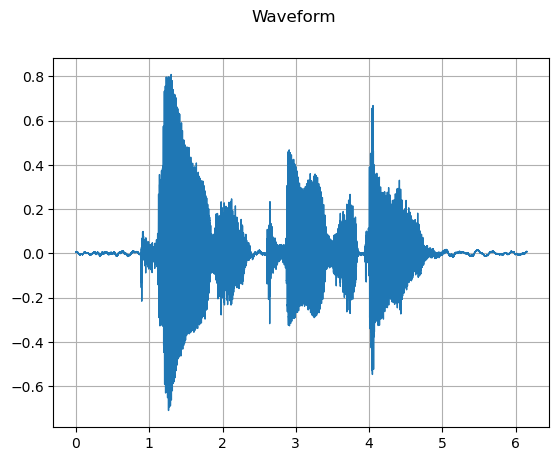

In [7]:
import torch
f = "/data/ephraim/datasets/vctk/VCTK-Corpus-0.92/wav48_silence_trimmed/p225/p225_001_mic1.flac"
noisy_signal_, sr =torchaudio.load(f)
print(sr)
plot_waveform(noisy_signal_)
# calc_vad(f, True)

In [5]:
calc_vad(f, True)

ValueError: File format b'fLaC' not understood. Only 'RIFF' and 'RIFX' supported.

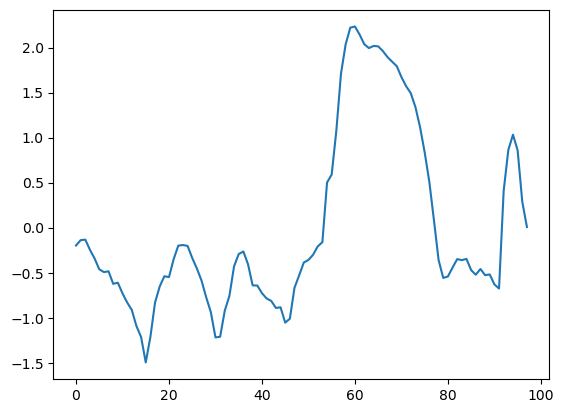

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


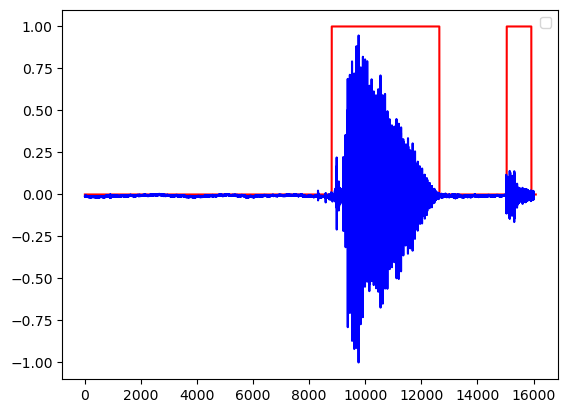

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [146]:
calc_vad(f, True)

In [2]:


filenames = glob(f'/data/ephraim/datasets/sc09/wavs/*.wav')


In [4]:
f = filenames[0]

In [156]:
vaded_signal = calc_vad(f)[0:noisy_signal_.shape[1],:]
vaded_signal_torch = (noisy_signal_[0][vaded_signal.T[0]>0])
vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
vaded_signal_torch.shape

torch.Size([1, 4720])

In [149]:
vaded_signal_torch

tensor([-0.0070, -0.0084, -0.0071,  ...,  0.0031, -0.0055, -0.0109])

In [7]:

noisy_signal_, sr =torchaudio.load(f)
power_x0_a = float(1 / noisy_signal_.shape[1] * torch.sum(noisy_signal_**2))
power_x0_a

0.0006341795669868588

In [157]:
power_x0_b =  1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2)
power_x0_b

tensor(0.0021)

In [159]:
simple_power = np.zeros(len(filenames))
clean_power = np.zeros(len(filenames))
for i,f in enumerate(filenames):
    noisy_signal_, sr =torchaudio.load(f)
    vaded_signal = calc_vad(f)[0:noisy_signal_.shape[1],:]
    vaded_signal_torch = (noisy_signal_[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    power_x0_a = float(1 / noisy_signal_.shape[1] * torch.sum(noisy_signal_**2))
    simple_power[i] = power_x0_a
    try:
        power_x0_b =  1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2)
    except:
        power_x0_b=0
    clean_power[i] = power_x0_b


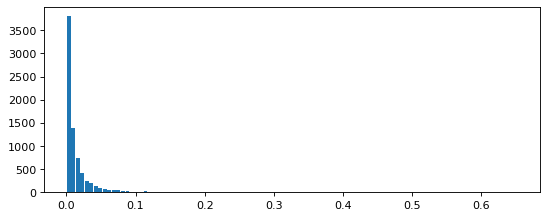

In [180]:
from matplotlib.pyplot import figure

figure(figsize=(8, 3), dpi=80)
n, bins, patches = plt.hist(x=clean_power,bins=100, rwidth=0.85)

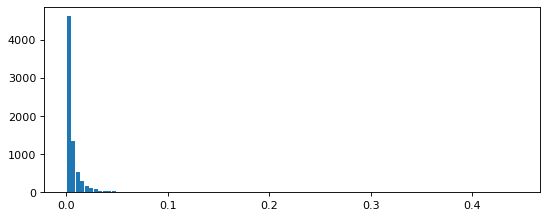

In [181]:
figure(figsize=(8, 3), dpi=80)
n, bins, patches = plt.hist(x=simple_power,bins=100, rwidth=0.85)

In [184]:
import pandas as pd
df_describe = pd.DataFrame(clean_power)
df_describe.describe()

,0
count,7398.000000
mean,0.015434
std,0.034641
min,0.000000
25%,0.001750
50%,0.006146
75%,0.015587
max,0.653375


In [185]:
import pandas as pd
df_describe = pd.DataFrame(simple_power)
df_describe.describe()

,0
count,7398.000000
mean,0.006896
std,0.016384
min,0.000028
25%,0.000735
50%,0.002720
75%,0.007065
max,0.445415


In [190]:
0.034641/0.015434


2.244460282493197

In [188]:
sum(clean_power==0)

1

In [35]:
print(len(noisy_signal_[0]))
(noisy_signal_[noisy_signal_>0.01]).shape

16000


torch.Size([1141])

In [13]:
display(Audio(noisy_signal_, rate=sr, autoplay=False))

In [155]:
x

tensor([[-0.0070, -0.0084, -0.0071,  ...,  0.0031, -0.0055, -0.0109]])

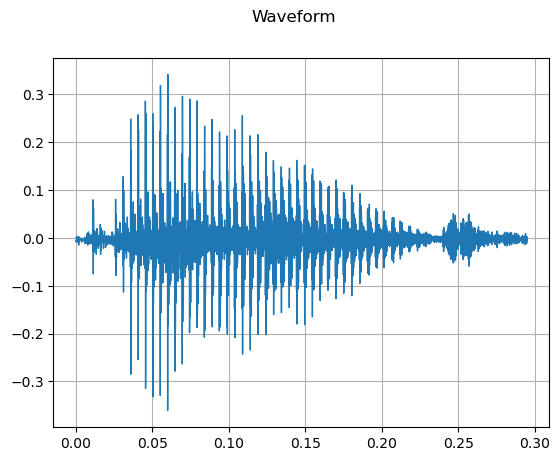

In [154]:
x = torch.unsqueeze(vaded_signal_torch, dim=0)
plot_waveform(x)

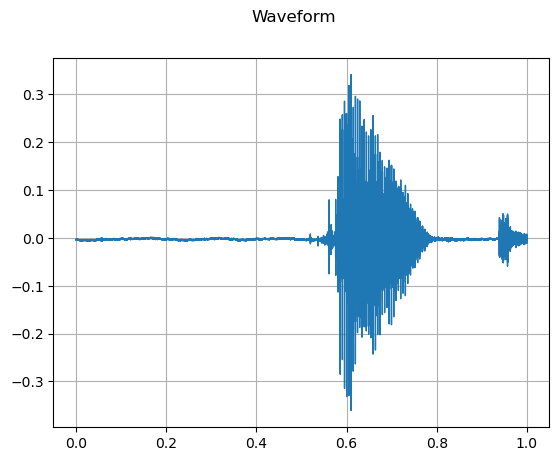

In [27]:
plot_waveform(noisy_signal_)

Sample Rate: 16000
Dtype: torch.float32
 - Max:      0.341
 - Min:     -0.361
 - Mean:    -0.003
 - Std Dev:  0.025

tensor([[-0.0035, -0.0028, -0.0039,  ...,  0.0037,  0.0023, -0.0063]])



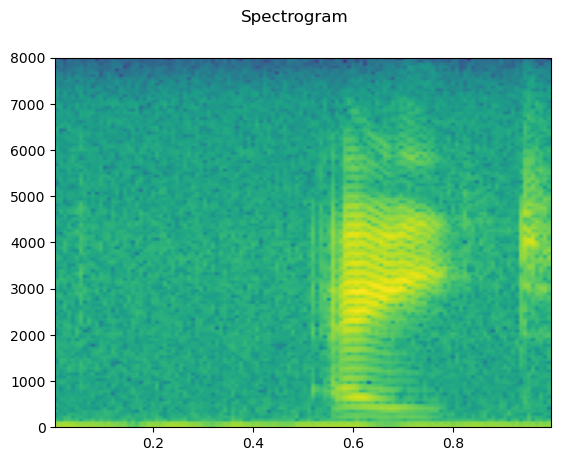

In [28]:

print_stats(noisy_signal_)

plot_specgram(noisy_signal_, 16000)

In [18]:
from scipy.io.wavfile import read
input_data = read(f)
audio = input_data[1]

In [21]:
max(audio)

11187

In [20]:
torch.max(noisy_signal_)

tensor(0.3414)

In [1]:
import json
with open("power_stats_5min.json") as f:
    d= json.load(f)

In [3]:
sample = d["samples"]


In [8]:
import pandas as pd
df = pd.DataFrame(sample)

In [11]:
df.describe()

,simple_power,clean_power
count,120.000000,120.000000
mean,0.014746,0.029344
std,0.007106,0.013666
min,0.005079,0.012693
25%,0.009647,0.019668
50%,0.012863,0.025652
75%,0.017631,0.034643
max,0.045431,0.083208


In [12]:
print(0.007106/0.014746)
print(0.013666/0.029344)

0.48189339481893395
0.465717011995638


In [2]:
import pandas as pd

import json
with open("power_stats.json") as f:
    d= json.load(f)
sample2 = d["samples"]
df2 = pd.DataFrame(sample2)
df2.describe()

,simple_power,clean_power
count,100.000000,100.000000
mean,0.013460,0.030451
std,0.019596,0.044710
min,0.000021,0.000030
25%,0.002587,0.005545
50%,0.007787,0.016293
75%,0.014438,0.033422
max,0.114814,0.265932


In [12]:
working = "/data/ephraim/datasets/known_noise/undiff/exp5/a/clean_wav/LJ002-0309.wav"
speech_w, sr = torchaudio.load(working)

vaded_signal = calc_vad(working)[0:speech_w.shape[1],:]
print("vaded_signal: ", vaded_signal)
vaded_signal_torch = (speech_w[0][vaded_signal.T[0]>0])
vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
# raise Exception
clean_power2 = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
print("clean_power: ", clean_power2)
simple_power2 =  1 / speech_w.shape[1] * torch.sum(speech_w**2)
print("simple_power: ", simple_power2)

vaded_signal:  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
clean_power:  0.010637924075126648
simple_power:  tensor(0.0076)


In [8]:
small = "/data/ephraim/datasets/known_noise/undiff/exp6/b/clean_wav/book_07573_chp_0022_reader_00215_21_mHrEmQZy60E_snr-4_fileid_413.wav"
big = "/data/ephraim/datasets/known_noise/undiff/exp6b/clean_wav/book_07573_chp_0022_reader_00215_21_mHrEmQZy60E_snr-4_fileid_413.wav"

In [15]:
speech, sr = torchaudio.load(small)


vaded_signal = calc_vad(small)[0:speech.shape[1],:]
print("vaded_signal: ", vaded_signal)
vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
# raise Exception
clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
print("clean_power: ", clean_power)
simple_power =  1 / speech.shape[1] * torch.sum(speech**2)
print("simple_power: ", simple_power)

vaded_signal:  [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
clean_power:  0.0003898124268744141
simple_power:  tensor(0.0003)


In [16]:
bigger_torch = speech*5
from IPython.display import Audio, display

display(Audio(bigger_torch, rate=sr, autoplay=False))

In [17]:
display(Audio(speech, rate=sr, autoplay=False))

In [ ]:
# vaded_signal = calc_vad(small)[0:speech.shape[1],:]
# print("vaded_signal: ", vaded_signal)
# vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
# vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
# # raise Exception
# clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
# print("clean_power: ", clean_power)
# simple_power =  1 / speech.shape[1] * torch.sum(speech**2)
# print("simple_power: ", simple_power)

In [ ]:
noise_power = 1 / noise.shape[1] * torch.sum(noise**2)
# noise_power = clean_power_noise
speech_power = clean_power
noise_power_target = speech_power * np.power(10, -snr / 10)
noise_scaling = np.sqrt(noise_power_target / noise_power)
lossy_speech = speech + noise_scaling * noise

In [26]:
import numpy as np 
linear_array = np.linspace(0, 1, num=10) 
(linear_array)


array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [29]:
linear_array = np.linspace(0.04, 1, num=10)
(linear_array)

array([0.04      , 0.14666667, 0.25333333, 0.36      , 0.46666667,
       0.57333333, 0.68      , 0.78666667, 0.89333333, 1.        ])

[0.5        0.67101007 0.8213938  0.9330127  0.99240388 0.99240388
 0.9330127  0.8213938  0.67101007 0.5       ]


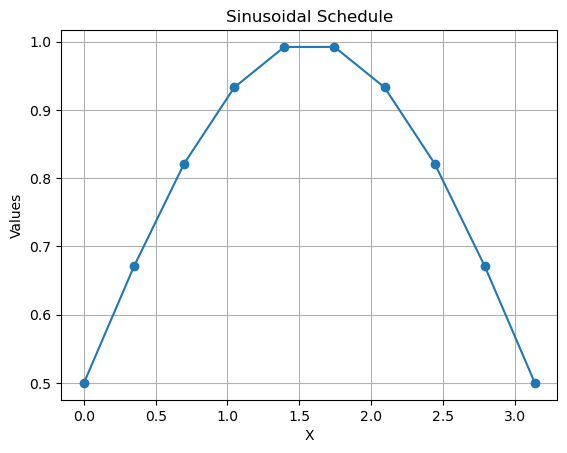

In [4]:
import matplotlib.pyplot as plt

# Generate sinusoidally spaced numbers between 0 and 1
num_points = 10
x = np.linspace(0, np.pi, num_points)  # Adjust num_points for desired granularity
sinusoidal_array = (np.sin(x) + 1) / 2

print(sinusoidal_array)

# Plot the sinusoidal schedule
plt.plot(x, sinusoidal_array, marker='o')
plt.xlabel('X')
plt.ylabel('Values')
plt.title('Sinusoidal Schedule')
plt.grid(True)
plt.show()

[0.00000000e+00 6.23052412e-05 2.49205437e-04 5.60654008e-04
 9.96573334e-04 1.55685478e-03 2.24135870e-03 3.04991451e-03
 3.98232070e-03 5.03834490e-03 6.21772392e-03 7.52016383e-03
 8.94534004e-03 1.04928974e-02 1.21624501e-02 1.39535822e-02
 1.58658473e-02 1.78987687e-02 2.00518399e-02 2.23245242e-02
 2.47162553e-02 2.72264370e-02 2.98544439e-02 3.25996208e-02
 3.54612837e-02 3.84387194e-02 4.15311859e-02 4.47379124e-02
 4.80580998e-02 5.14909205e-02 5.50355191e-02 5.86910122e-02
 6.24564888e-02 6.63310103e-02 7.03136113e-02 7.44032991e-02
 7.85990545e-02 8.28998319e-02 8.73045594e-02 9.18121393e-02
 9.64214481e-02 1.01131337e-01 1.05940633e-01 1.10848136e-01
 1.15852624e-01 1.20952850e-01 1.26147542e-01 1.31435406e-01
 1.36815124e-01 1.42285356e-01 1.47844737e-01 1.53491883e-01
 1.59225386e-01 1.65043817e-01 1.70945726e-01 1.76929643e-01
 1.82994075e-01 1.89137512e-01 1.95358422e-01 2.01655256e-01
 2.08026443e-01 2.14470396e-01 2.20985509e-01 2.27570159e-01
 2.34222703e-01 2.409414

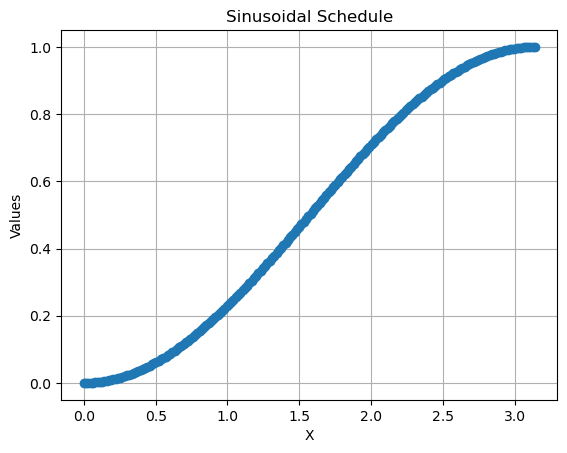

In [25]:


# Generate sinusoidally spaced numbers between 0 and 1
num_points = 200
x = np.linspace(0, np.pi, num_points)  # Adjust num_points for desired granularity
sinusoidal_array =  (np.sin(x - np.pi/2) + 1) / 2
# x_ = np.linspace(0, np.pi, len(alphas))  
#         self.s_guid_scheduler_sinusoidal = 1-(np.sin(x_ - np.pi/2) + 1) / 2
print(sinusoidal_array)

# Plot the sinusoidal schedule
plt.plot(x, sinusoidal_array, marker='o')
plt.xlabel('X')
plt.ylabel('Values')
plt.title('Sinusoidal Schedule')
plt.grid(True)
plt.show()

In [24]:
sinusoidal_array

array([1.00000000e+00, 9.99937695e-01, 9.99750795e-01, 9.99439346e-01,
       9.99003427e-01, 9.98443145e-01, 9.97758641e-01, 9.96950085e-01,
       9.96017679e-01, 9.94961655e-01, 9.93782276e-01, 9.92479836e-01,
       9.91054660e-01, 9.89507103e-01, 9.87837550e-01, 9.86046418e-01,
       9.84134153e-01, 9.82101231e-01, 9.79948160e-01, 9.77675476e-01,
       9.75283745e-01, 9.72773563e-01, 9.70145556e-01, 9.67400379e-01,
       9.64538716e-01, 9.61561281e-01, 9.58468814e-01, 9.55262088e-01,
       9.51941900e-01, 9.48509079e-01, 9.44964481e-01, 9.41308988e-01,
       9.37543511e-01, 9.33668990e-01, 9.29686389e-01, 9.25596701e-01,
       9.21400945e-01, 9.17100168e-01, 9.12695441e-01, 9.08187861e-01,
       9.03578552e-01, 8.98868663e-01, 8.94059367e-01, 8.89151864e-01,
       8.84147376e-01, 8.79047150e-01, 8.73852458e-01, 8.68564594e-01,
       8.63184876e-01, 8.57714644e-01, 8.52155263e-01, 8.46508117e-01,
       8.40774614e-01, 8.34956183e-01, 8.29054274e-01, 8.23070357e-01,
      

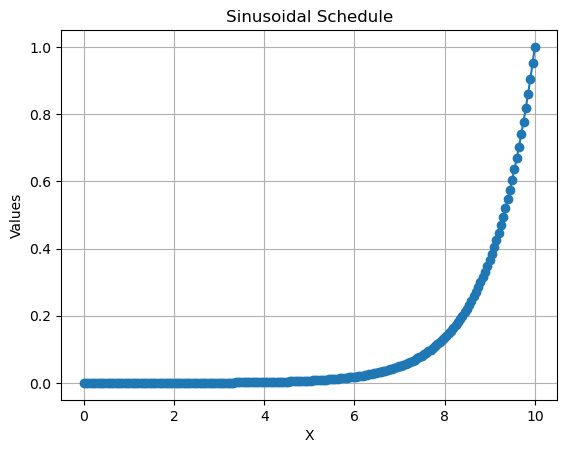

In [20]:
# Generate sinusoidally spaced numbers between 0 and 1
num_points = 200
x = np.linspace(10, 0, num_points)  # Adjust num_points for desired granularity
exp_array = (np.exp(x))/(np.exp(x[0]))

# print(exp_array)

# Plot the sinusoidal schedule
plt.plot(x, exp_array, marker='o')
plt.xlabel('X')
plt.ylabel('Values')
plt.title('Sinusoidal Schedule')
plt.grid(True)
plt.show()

In [2]:
import numpy as np
num_points = 200
x = np.linspace(1, 0, num_points)  # Adjust num_points for desired granularity
exp_array = (np.exp(x))/(np.exp(x[0]))

# print(exp_array)

# Plot the sinusoidal schedule
plt.plot(x, exp_array, marker='o')
plt.xlabel('X')
plt.ylabel('Values')
plt.title('Sinusoidal Schedule')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [23]:
exp_array

array([1.00000000e+00, 9.50990452e-01, 9.04382840e-01, 8.60059446e-01,
       8.17908321e-01, 7.77823004e-01, 7.39702251e-01, 7.03449778e-01,
       6.68974022e-01, 6.36187908e-01, 6.05008626e-01, 5.75357427e-01,
       5.47159420e-01, 5.20343384e-01, 4.94841590e-01, 4.70589627e-01,
       4.47526243e-01, 4.25593184e-01, 4.04735054e-01, 3.84899172e-01,
       3.66035438e-01, 3.48096207e-01, 3.31036169e-01, 3.14812236e-01,
       2.99383431e-01, 2.84710784e-01, 2.70757237e-01, 2.57487547e-01,
       2.44868199e-01, 2.32867319e-01, 2.21454597e-01, 2.10601208e-01,
       2.00279738e-01, 1.90464118e-01, 1.81129558e-01, 1.72252480e-01,
       1.63810464e-01, 1.55782187e-01, 1.48147373e-01, 1.40886737e-01,
       1.33981942e-01, 1.27415547e-01, 1.21170969e-01, 1.15232435e-01,
       1.09584945e-01, 1.04214236e-01, 9.91067439e-02, 9.42495672e-02,
       8.96304385e-02, 8.52376912e-02, 8.10602305e-02, 7.70875053e-02,
       7.33094815e-02, 6.97166169e-02, 6.62998371e-02, 6.30505120e-02,
      